In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import math
import random
import traceback
import sqlite3
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.metrics import make_scorer
from scipy.stats import uniform
from scipy.sparse import find
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec

c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con1 = sqlite3.connect("database.sqlite")

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000", con1)

def polarity(x):
    if x > 3:
        return "positive"
    else:
        return "negetive"
    
filtered_data["Score"] = filtered_data["Score"].map(polarity)
print(filtered_data.shape)
filtered_data.head()

(5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
sorted_data = filtered_data.sort_values("ProductId",axis=0, ascending = True, inplace = False, kind = "quicksort", \
                                       na_position = "last")

final = sorted_data.drop_duplicates(subset={"UserId","ProfileName", "Time", "Text"}, keep = "first", inplace = False)
print(final.shape)

(4986, 10)


In [4]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.shape

(4986, 10)

## Text-Preprocssing

In [5]:
#set of stopwords in English
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [6]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
import re

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [7]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (4986, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,positive,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodl puppi love stuff tr...


In [8]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## BoW

In [9]:
x = final["CleanedText"].values
y = final["Score"]

X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.3,random_state=0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(X_test.shape)

(3490,)
(3490,)
(1496,)
(1496,)


In [10]:
count_vect = CountVectorizer(min_df=10)
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)

print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (3490, 1501)
the number of unique words : 1501


## RF with GridSearchCV

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {"n_estimators":base_learners, "max_depth":depth}

RFC = RandomForestClassifier(max_features = "sqrt")

model = GridSearchCV(RFC, param_grid, scoring = "f1_weighted", cv=3 , n_jobs = -1 , pre_dispatch = 2)

model.fit(X_train_vec, Y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners are: ", optimal_learners)

optimal_depth = model.best_estimator_.max_depth
print("The optimal depth is: ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8425639390291307
The optimal number of base learners are:  10
The optimal depth is:  90


Best Hyperparameters:  {'max_depth': 90, 'n_estimators': 10}
0.8286071630508244


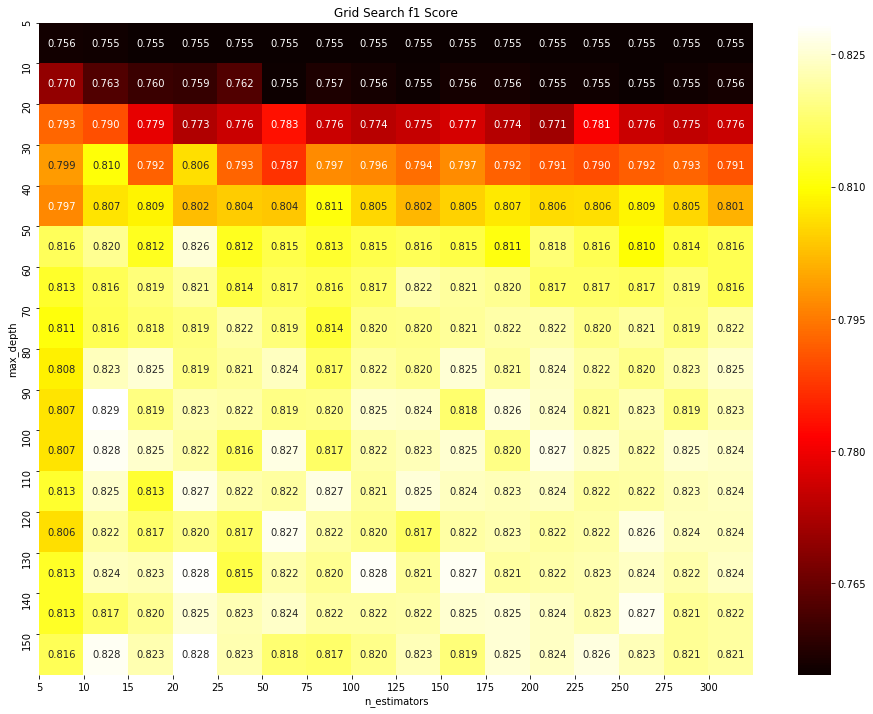

In [12]:
import seaborn as sns

print("Best Hyperparameters: ",model.best_params_)
print(model.best_score_)

scores = model.cv_results_["mean_test_score"].reshape(len(base_learners), len(depth))

plt.figure(figsize=(16, 12))

sns.heatmap(scores, annot = True, cmap = plt.cm.hot, fmt = ".3f", xticklabels = base_learners, yticklabels = depth)

plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()


Accuracy of the model at optimal hyperparameter depth = 10 is:  85.628342%
Confusion matrix for the model is:


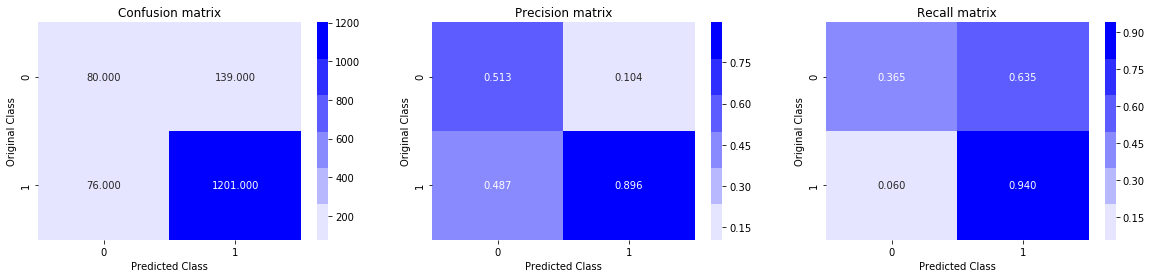

f1 score value for   the model is: 0.845941100864565
precision score  for   the model is: 0.8962686567164179


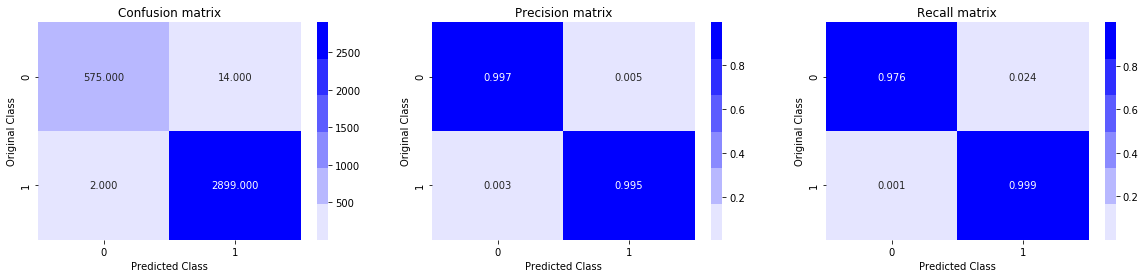

Accuracy of the model at optimal hyperparameter depth = 10 is:  99.541547%
f1 score value for   the model is: 0.995396612924449
precision score  for   the model is: 0.9951939581187779


In [13]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## GBDT with GridSearchCV

In [14]:
# Importing library
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3, n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of learning rate
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of max depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=225,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8324369735844259
The optimal number of base learners is :  225

The optimal value of max depth is :  5


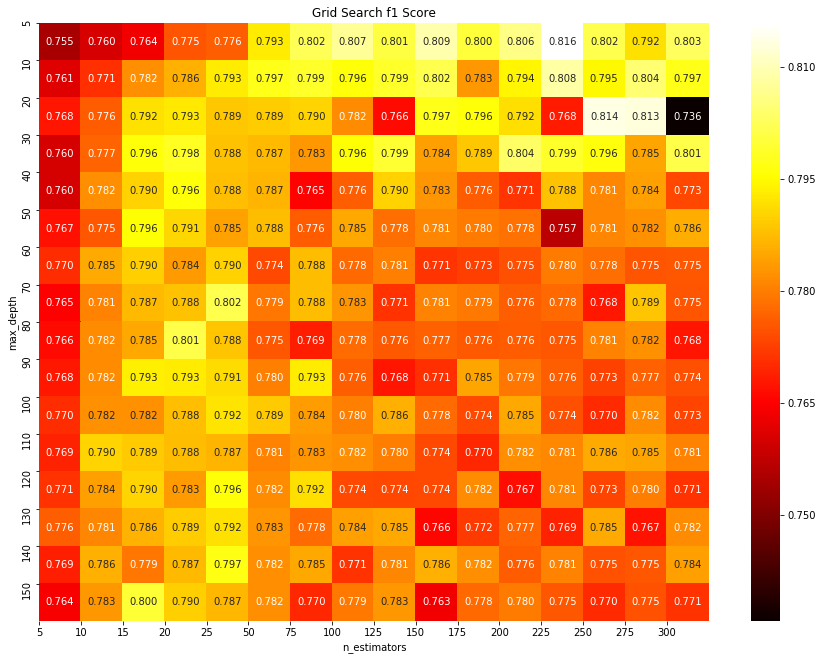

In [15]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(15, 11))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 225 is:  85.026738%
Confusion matrix for the model is:


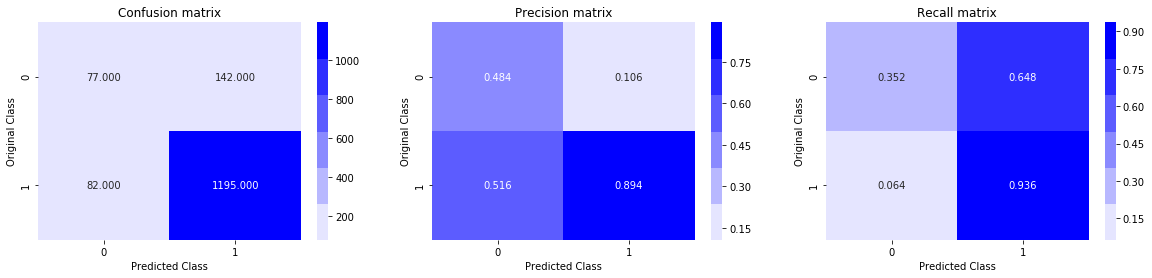

f1 score value for   the model is: 0.8401022693745139
precision score  for   the model is: 0.893792071802543


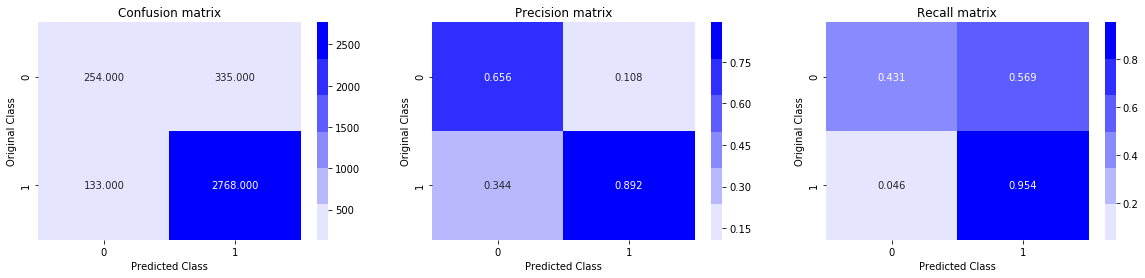

Accuracy of the model at optimal hyperparameter estimator = 225 is:  86.590258%
f1 score value for   the model is: 0.8542814967421628
precision score  for   the model is: 0.8920399613277473


In [16]:
import seaborn as sns
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## TF-IDF

In [17]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)

print(X_train_vec.shape)
print(X_test_vec.shape)

(3490, 1501)
(1496, 1501)


## RF with GridSearchCV

In [21]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {"n_estimators":base_learners , "max_depth":depth}

RFC = RandomForestClassifier(max_features = "sqrt")

model = GridSearchCV(RFC , param_grid, scoring = "f1_weighted", cv = 3, n_jobs = -1 , pre_dispatch = 2)

model.fit(X_train_vec, Y_train)

print("Model with best parameters: ", model.best_estimator_)
print("Accuracy of model: ", model.score(X_test_vec, Y_test))

optimal_learners = model.best_estimator_.n_estimators
print("optimal number of base learners is: ", optimal_learners)

optimal_depth = model.best_estimator_.max_depth
print("optimal number of depth is: ", optimal_depth)

Model with best parameters:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=130, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of model:  0.8559694969438529
optimal number of base learners is:  10
optimal number of depth is:  130


Best HyperParameter:  {'max_depth': 130, 'n_estimators': 10}
0.8305255674435451


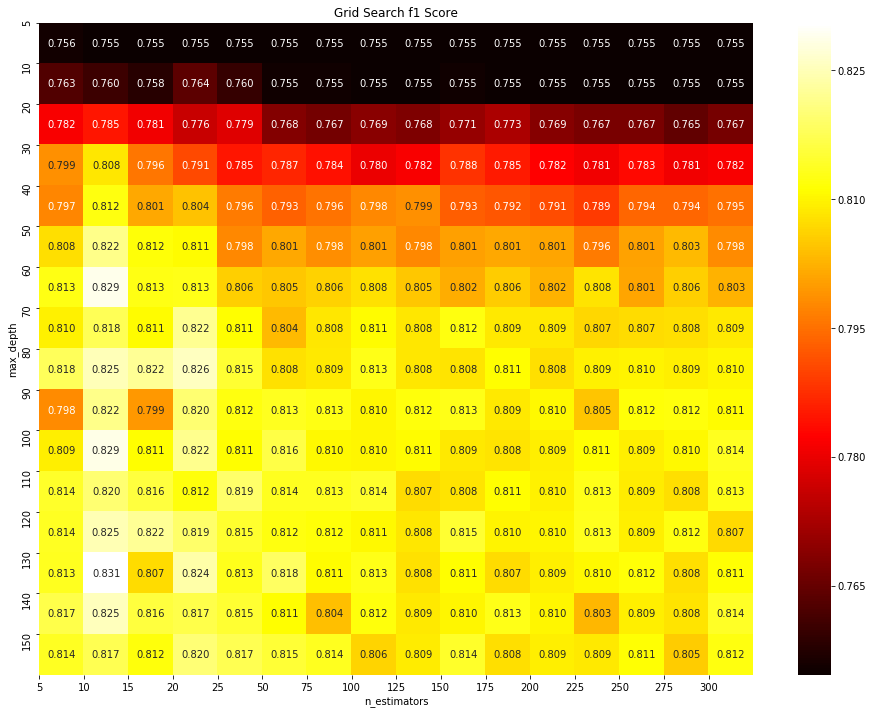

In [22]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 10 is:  87.767380%
Confusion matrix for the model is:


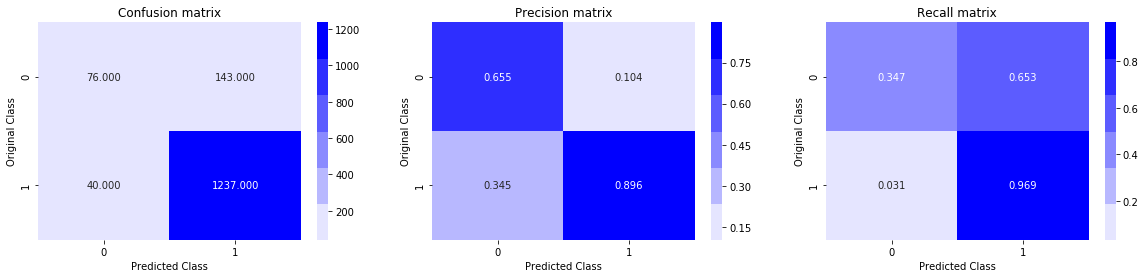

f1 score value for   the model is: 0.8612394449994567
precision score  for   the model is: 0.8963768115942029


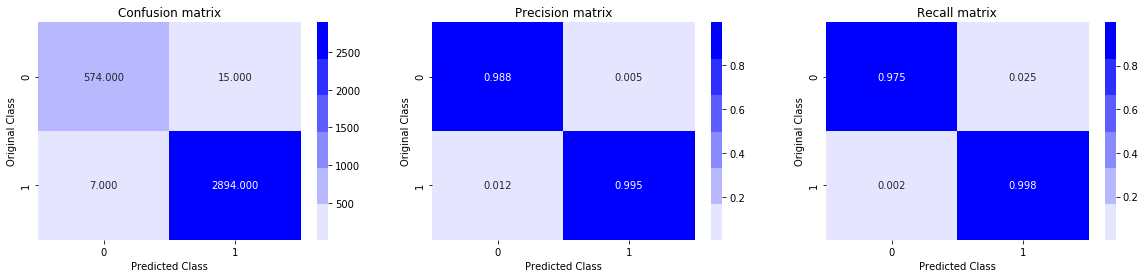

Accuracy of the model at optimal hyperparameter depth = 10 is:  99.369628%
f1 score value for   the model is: 0.9936790637891891
precision score  for   the model is: 0.994843588862152


In [23]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## GBDT with GridSearchCV

In [24]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8460731142435746
The optimal number of base learners is :  300

The optimal value of depth is :  5


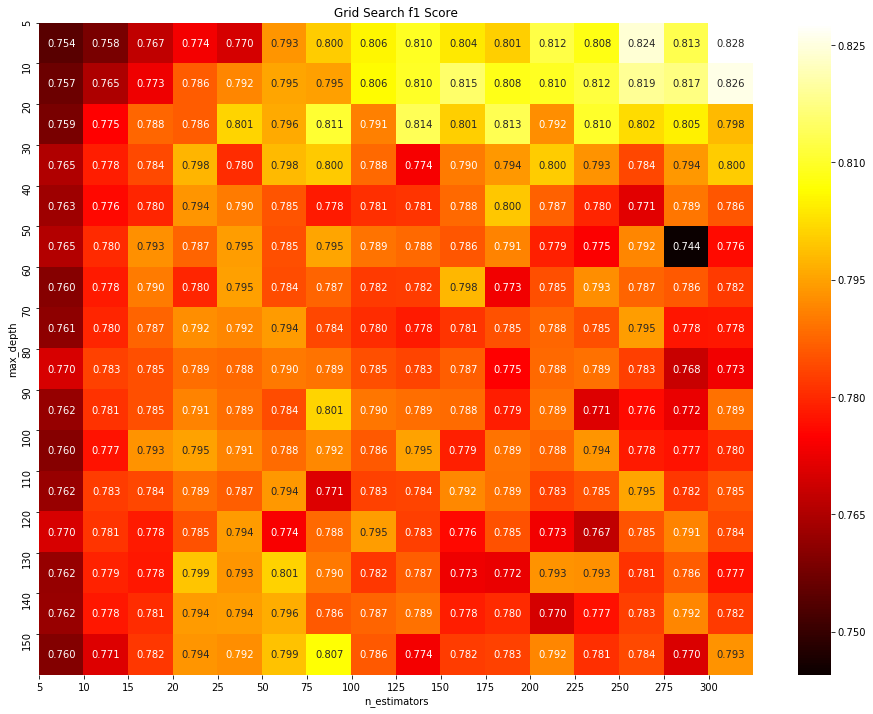

In [25]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 300 is:  86.430481%
Confusion matrix for the model is:


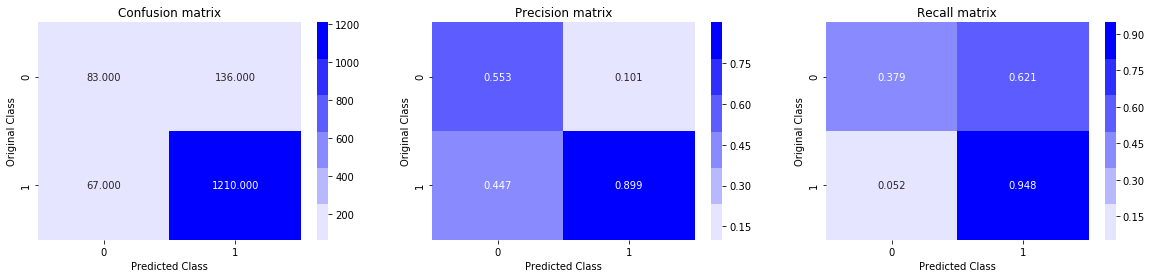

f1 score value for   the model is: 0.8534026467346982
precision score  for   the model is: 0.8989598811292719


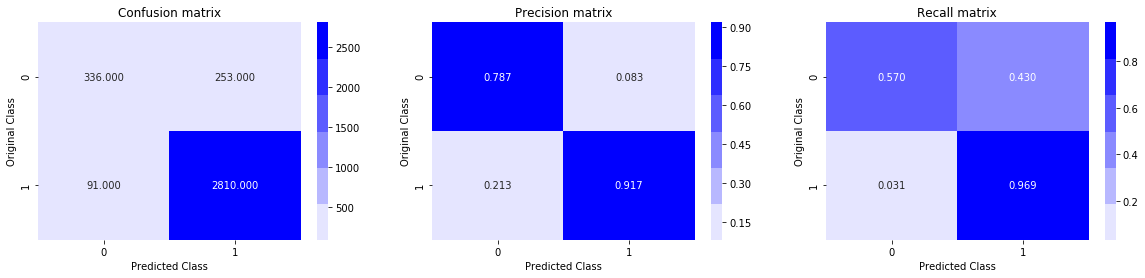

Accuracy of the model at optimal hyperparameter estimator = 300 is:  90.143266%
f1 score value for   the model is: 0.894913133336036
precision score  for   the model is: 0.9174012406137774


In [26]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## Avg Word2Vec

In [27]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  2492


In [28]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)

In [29]:
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
X_train_vec = train_vectors
X_test_vec = test_vectors

## RF with GridSearchCV

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features=0.2)
model = GridSearchCV(RFC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8529411764705882
The optimal number of base learners is :  15
The optimal number of depth is :  5


Best HyperParameter:  {'max_depth': 5, 'n_estimators': 15}
0.8312320916905445


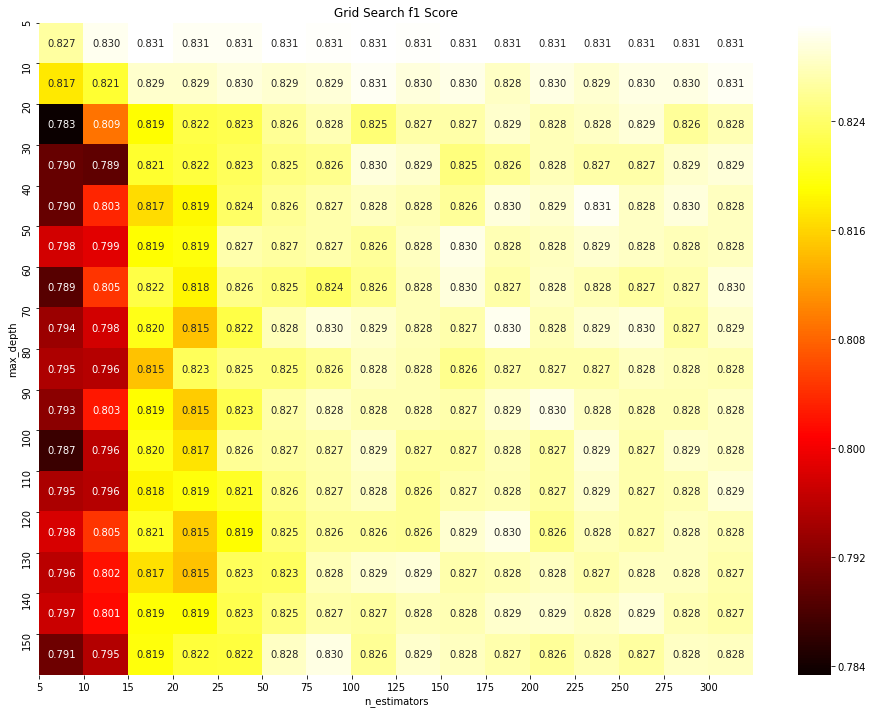

In [31]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 15 is:  85.227273%
Confusion matrix for the model is:


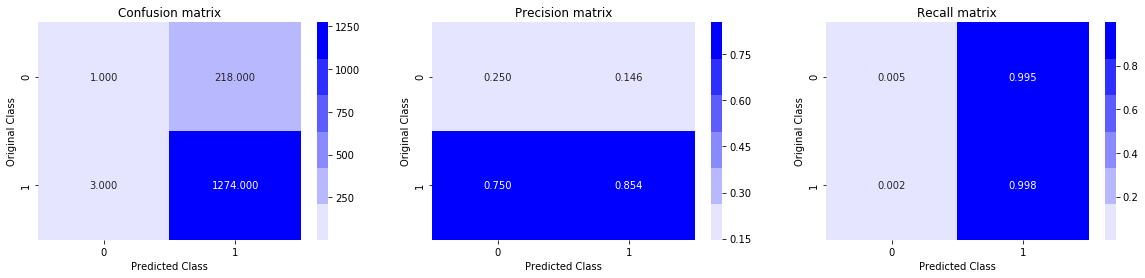

f1 score value for   the model is: 0.8522727272727273
precision score  for   the model is: 0.853887399463807


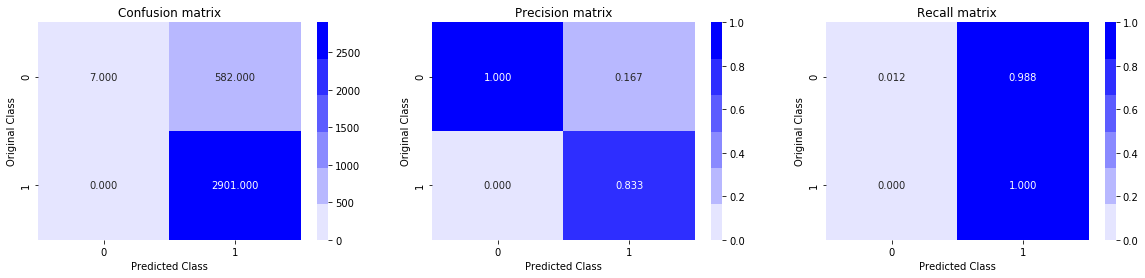

Accuracy of the model at optimal hyperparameter depth = 15 is:  83.323782%
f1 score value for   the model is: 0.8332378223495702
precision score  for   the model is: 0.8329026701119724


In [32]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## GBDT with GridSearchCV

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.794157280668267
The optimal number of base learners is :  75

The optimal value of depth is :  5


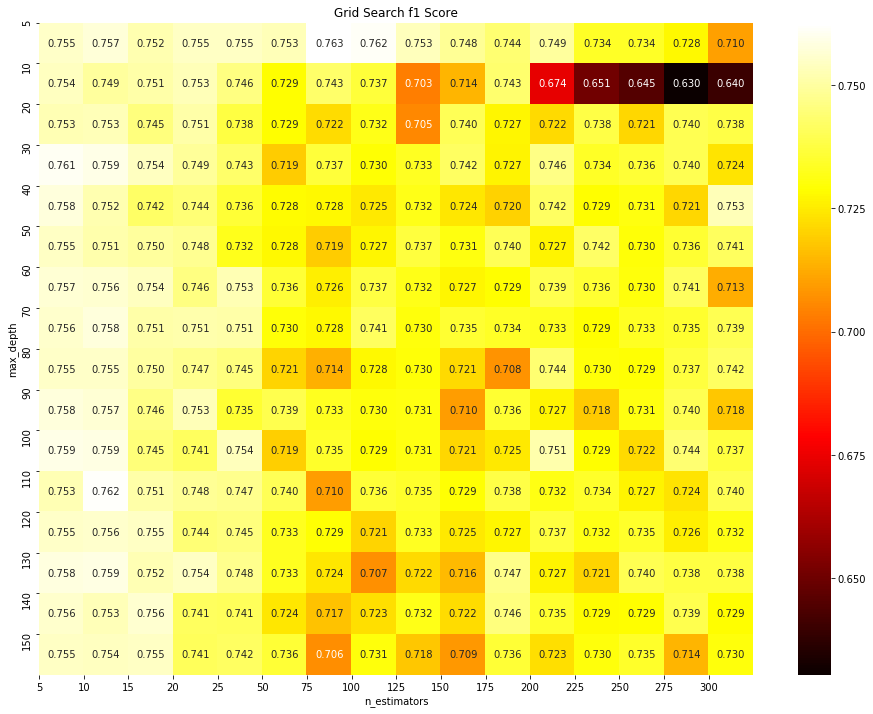

In [34]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 75 is:  81.751337%
Confusion matrix for the model is:


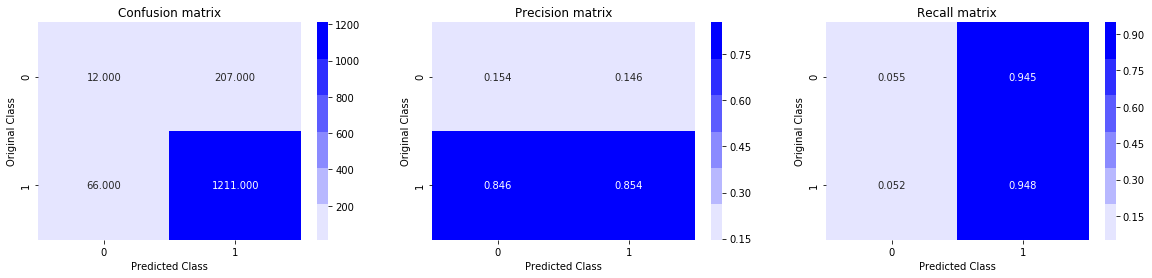

f1 score value for   the model is: 0.7789696043706739
precision score  for   the model is: 0.8540197461212976


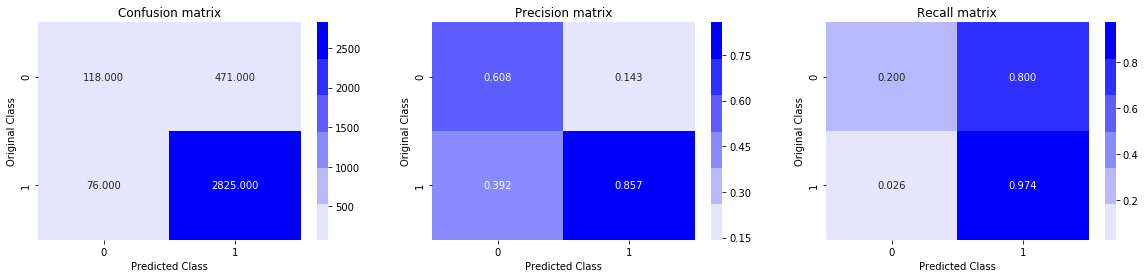

Accuracy of the model at optimal hyperparameter estimator = 75 is:  84.326648%
f1 score value for   the model is: 0.8087279342708562
precision score  for   the model is: 0.8570995145631068


In [35]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## TF-IDF Word2Vec

In [36]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [37]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
X_train_vec = tfidf_train_vectors
X_test_vec = tfidf_test_vectors

## RF with GridSearchCV

In [38]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8348930481283422
The optimal number of base learners is :  200
The optimal number of depth is :  40


Best HyperParameter:  {'max_depth': 40, 'n_estimators': 200}
0.832378223495702


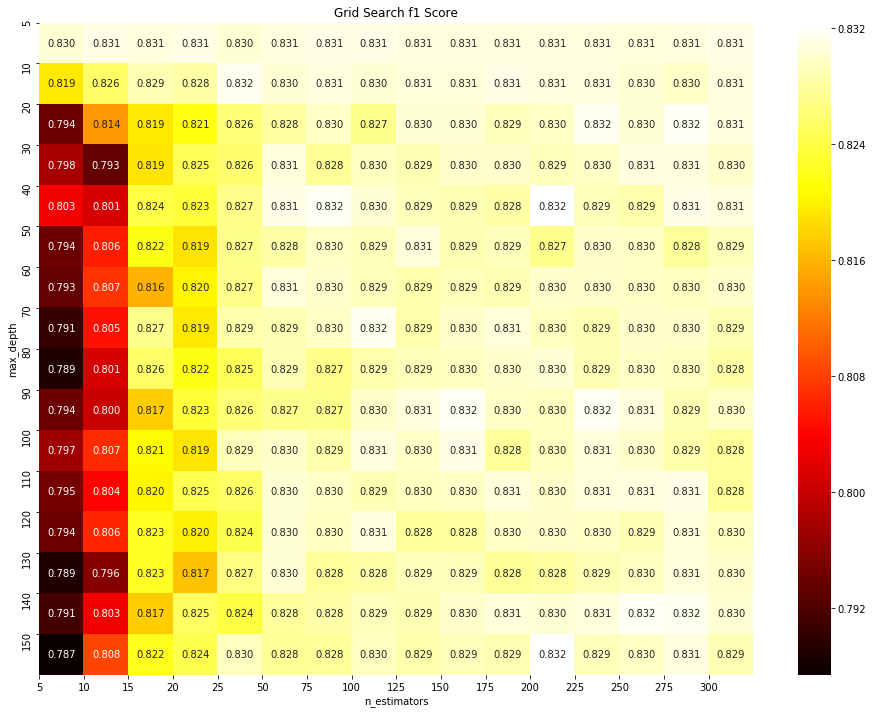

In [39]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 200 is:  83.489305%
Confusion matrix for the model is:


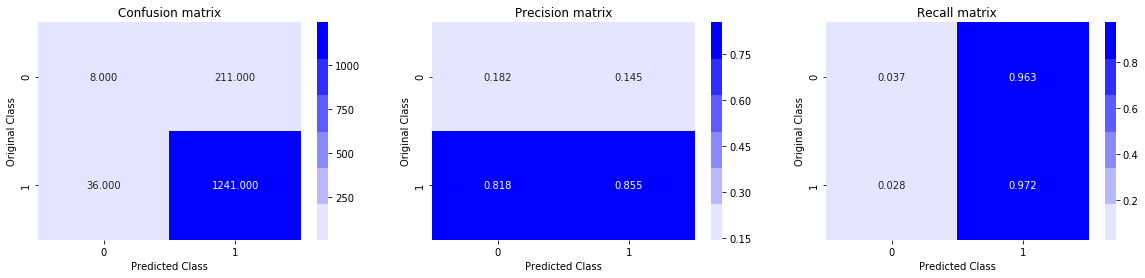

f1 score value for   the model is: 0.8348930481283422
precision score  for   the model is: 0.8546831955922864


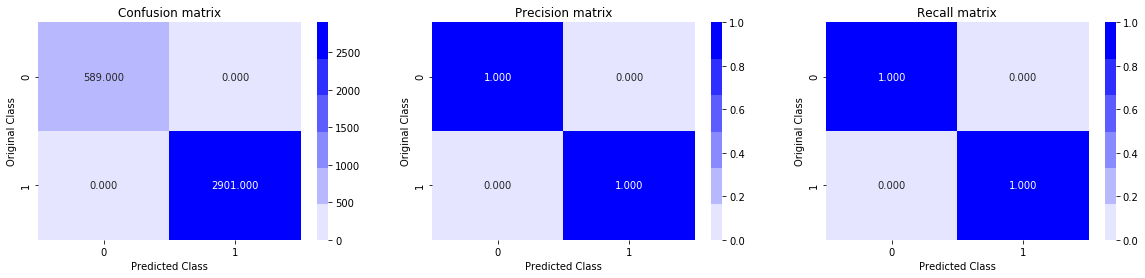

Accuracy of the model at optimal hyperparameter depth = 200 is:  100.000000%
f1 score value for   the model is: 1.0
precision score  for   the model is: 1.0


In [40]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

## GBDT with GridSearchCV

In [41]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=0.1, verbose=0,
              warm_start=False)
Accuracy of the model :  0.8509358288770054
The optimal number of base learners is :  5

The optimal value of depth is :  5


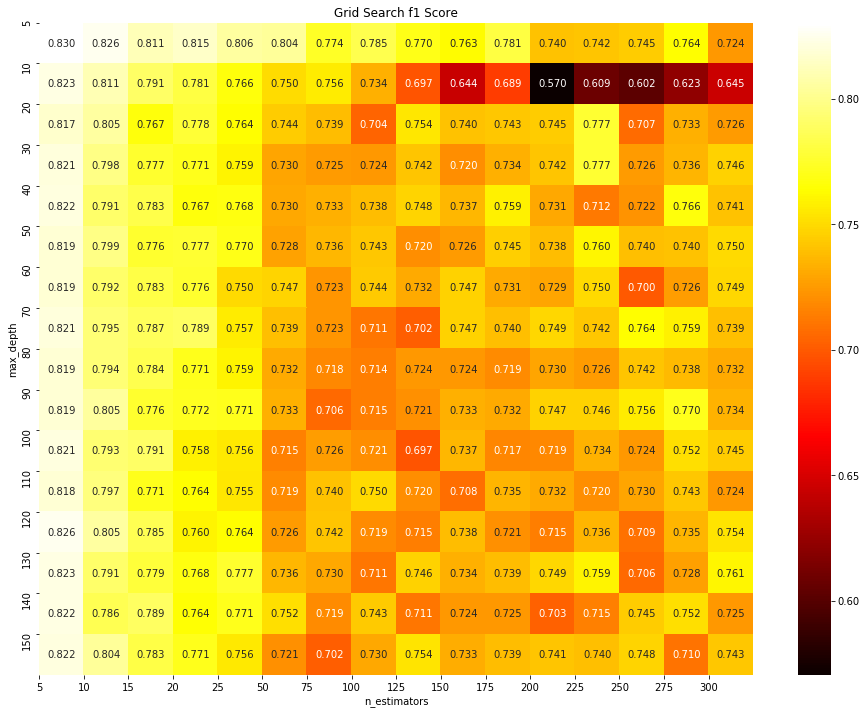

In [42]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 5 is:  81.016043%
Confusion matrix for the model is:


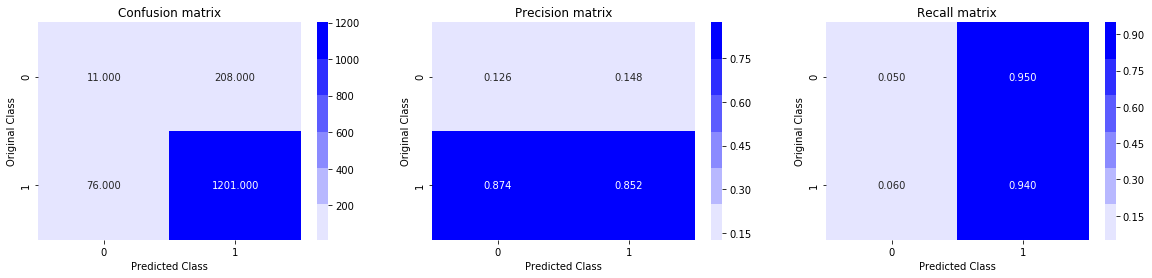

f1 score value for   the model is: 0.8101604278074866
precision score  for   the model is: 0.8523775727466288


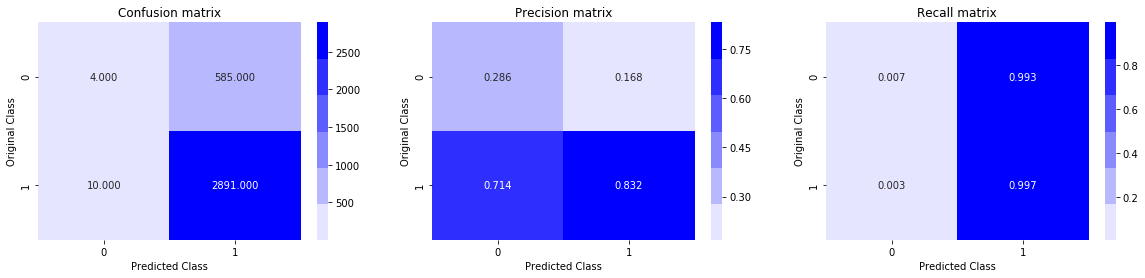

Accuracy of the model at optimal hyperparameter estimator = 5 is:  82.951289%
f1 score value for   the model is: 0.829512893982808
precision score  for   the model is: 0.8317031070195627


In [43]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)